In [ ]:
import pandas as pd
import json
import tweepy
import datetime
import text_prepocessing as tp
import re
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import nltk
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Visualizattion
import os
from os import path
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_gradient_magnitude
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [ ]:
with open("token.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=False)

In [ ]:
def getTweets(query, num_data, time_to_the_past):
    today = datetime.datetime.now()
    start_date = datetime.datetime.now() - datetime.timedelta(time_to_the_past)
    day_diff = (today.date() - start_date.date()).days + 1

    tweets = []
    date = []
    for single_date in (start_date + datetime.timedelta(n) for n in range(day_diff)):
        response = tweepy.Cursor(api.search_tweets,
                                    q=query,
                                    until=(single_date + datetime.timedelta(1)).date(),
                                    tweet_mode='extended',
                                    ).items(limit=num_data)
        for tweet in response:
            tweets.append(tweet.full_text.strip())
            date.append(str(tweet.created_at.date()))

    df = pd.DataFrame({'date': date, 'tweets': tweets})
    return df


In [ ]:
# Mengambil data dari twitter
query = "mahasiswa -filter:retweets lang:id"
df1 = getTweets(query, 150, 5)
df1.head()

,date,tweets
0,2022-04-05,"@sharonanneth @Dennysiregar7 bener banget, ngg..."
1,2022-04-05,"@NasionalisSiber Mahasiswa kok dongok, kwalita..."
2,2022-04-05,@Android_AK_47 Jangan biarkan Mahasiswa Berger...
3,2022-04-05,#temanpemilih #sedulurkpubanyumas KPU Banyumas...
4,2022-04-05,"@J4YIES aku bisaa, 2k per nomor, langsung dm a..."


In [ ]:
# Melakukan text prepocessing terhadap data dari twitter
tp.slangs = {
    'tp': 'tetapi',
    'msh': 'masih',
    'dpt': 'dapat',
    'dapet': 'dapat',
    'rb': 'ribu',
    'jd': 'jadi',
    'bener': 'benar',
    'dimn': 'dimana',
    'blg': 'bilang',
    'ga': 'tidak',
    'gk': 'tidak',
    'gak': 'tidak',
    'dgn': 'dengan',
    'bwt': 'buat',
    'jg': 'juga',
    'klo': 'kalau',
    'kalo': 'kalau',
    'sampe': 'sampai',
    'mengsedih': 'sedih',
    'yg': 'yang',
    'pake': 'pakai',
    'aja': 'saja',
    'sm': 'sama',
    'fess': '',
    'gue': 'saya',
    'udah': 'sudah',
    'udh': 'sudah',
    'tau': 'tahu',
    'trus': 'terus',
    'konven': 'konvensional',
    'duit': 'uang',
    'emang': 'memang',
    'invest': 'investasi',
    'cuan': 'untung',
    'setop': 'berhenti',
    'skrg': 'sekarang',
    'utk': 'untuk',
    'antaranews': '',
    'aremaniainfo': '',
    'investnow': 'investasi sekarang',
    'wkwk': '',
    'nder': '',
    'ni': '',
    'agunggtg': '',
    'sih': '',
    'kasih': 'bagi',
    'rejim': 'rezim',
    'adek': 'adik',
    'gera': 'segera',
    'krn': 'karena',
    'drakor': 'drama korea',
    'km': 'kamu',
    'kadrun': '',
    'mahasiswabergerak': 'mahasiswa bergerak',
    'banget': 'sangat',
    'nggak': 'tidak',
    'kwalitas': 'kualitas',
}

hasil = [tp.case_folding(item) for item in df1['tweets']]
hasil = [' '.join(tp.remove_stopwords(item)) for item in hasil]
hasil = [tp.stemming_sentence(item) for item in hasil]

df1['tweet_clean'] = hasil
df1.to_csv('tweets_mahasiswa.csv', index=False)
df1.head()

,date,tweets,tweet_clean
0,2022-04-05,"@sharonanneth @Dennysiregar7 bener banget, ngg...",bangga mahasiswa itb kalah ilmu ngembangin tek...
1,2022-04-05,"@NasionalisSiber Mahasiswa kok dongok, kwalita...",mahasiswa dongok kualitas mahasiswa
2,2022-04-05,@Android_AK_47 Jangan biarkan Mahasiswa Berger...,biar mahasiswa gerak rakyat buruh stm satu bar...
3,2022-04-05,#temanpemilih #sedulurkpubanyumas KPU Banyumas...,temanpemilih sedulurkpubanyumas kpu banyumas l...
4,2022-04-05,"@J4YIES aku bisaa, 2k per nomor, langsung dm a...",bisaa nomor dm wa diskusi nego mahasiswa sasin...


In [ ]:
def request_news(address, key, start_date, end_date, pages):
    date = []
    titles = []
    page = 1

    while page < pages + 1:
        request = f'search/searchall?query={key}&siteid=2&sortby=time&fromdatex={start_date}&todatex={end_date}&page={page}'
        html = urlopen(address + request)
        data = BeautifulSoup(html, 'html.parser')

        table = data.findAll("article")
        for row in table:
            article_title = row.find("h2", {"class": "title"})

            article_date = row.find("span", {"class": "date"})
            remove_tag = article_date.find("span", {"class": "category"}).extract()
            article_date = re.sub(r'^.*?,', '', article_date.get_text())
            article_date = datetime.datetime.strptime(article_date, ' %d %b %Y %H:%M WIB').strftime('%Y-%m-%d')
            titles.append(article_title.get_text())
            date.append(article_date)
        page += 1

    df = pd.DataFrame({'date': date, 'titles': titles})
    return df

In [ ]:
# Mengambil data tambahan dari webscrapping
df2 = request_news("https://www.detik.com/", 'mahasiswa', '05/04/2022', '10/04/2022', 20)


In [ ]:
# Melakukan text prepocessing terhadap data webscrapping
hasil = [tp.case_folding(item) for item in df2['titles']]
hasil = [' '.join(tp.remove_stopwords(item)) for item in hasil]
hasil = [tp.stemming_sentence(item) for item in hasil]

df2['title_clean'] = hasil
df2.to_csv('news_mahasiswa.csv', index=False)
df2.head()


,date,titles,title_clean
0,2022-04-10,"Soal Demo 11 April, Ketua PBNU Dorong Tuntutan...",demo april ketua pbnu dorong tuntut tutup
1,2022-04-10,"Unggah Demo 11 April Batal, Koordinator BEM SI...",unggah demo april batal koordinator bem si nga...
2,2022-04-10,Akhir Pelarian Pelaku Penyerangan Sekretariat ...,lari laku serang sekretariat mahasiswa kendari
3,2022-04-10,Mahfud Minta Pengamanan Demo 11 April Tanpa Ke...,mahfud aman demo april keras respons bem si
4,2022-04-10,Jokowi Diserang dan Dibela Usai Pilih Luhut Lagi,jokowi serang bela pilih luhut


In [ ]:
# Menggabungkan data dari tweet dan data dari webscrapping
df1 = pd.read_csv('tweets_mahasiswa.csv', delimiter=',')
df2 = pd.read_csv('news_mahasiswa.csv', delimiter=',')

df1_renamed = df1.rename({'tweet_clean': 'clean_data'}, axis=1)
df2_renamed = df2.rename({'title_clean': 'clean_data'}, axis=1)

df_clean = pd.concat([df1_renamed[['date', 'clean_data']], df2_renamed[['date', 'clean_data']]], ignore_index=True)
df_clean.to_csv('mahasiswa_clean.csv', index=False)
df_clean


,date,clean_data
0,2022-04-05,bangga mahasiswa itb kalah ilmu ngembangin tek...
1,2022-04-05,mahasiswa dongok kualitas mahasiswa
2,2022-04-05,biar mahasiswa gerak rakyat buruh stm satu bar...
3,2022-04-05,temanpemilih sedulurkpubanyumas kpu banyumas l...
4,2022-04-05,bisaa nomor dm wa diskusi nego mahasiswa sasin...
...,...,...
1069,2022-04-05,kisah puasa ramadhan jerman buka pakai nasi kotak
1070,2022-04-05,bongkar lemah disertasi cuci otak idi duga unh...
1071,2022-04-05,hmi mahasiswa demo kunjung jokowi jambi
1072,2022-04-05,prof henuk lapor musni umar mahasiswa uic duga...


Describe :         clean_data
count  1074.000000
mean     79.860335
std      45.300581
min       9.000000
25%      46.000000
50%      65.500000
75%     108.750000
max     232.000000
Skewness : clean_data    0.820643
dtype: float64


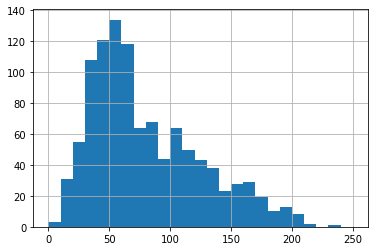

Describe :         clean_data
count  1074.000000
mean     11.645251
std       6.659740
min       1.000000
25%       7.000000
50%      10.000000
75%      16.000000
max      35.000000
Skewness : clean_data    0.831907
dtype: float64


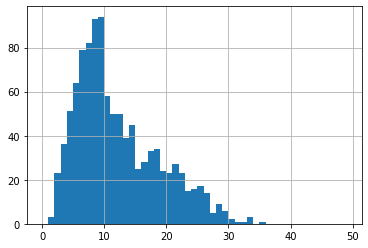

Describe :         clean_data
count  1074.000000
mean      6.105035
std       1.197879
min       3.666667
25%       5.375000
50%       5.857143
75%       6.500000
max      14.400000
Skewness : clean_data    2.064348
dtype: float64


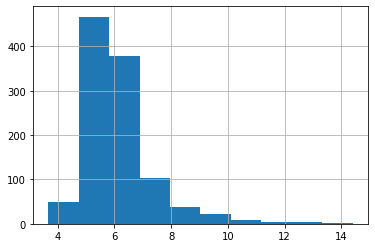

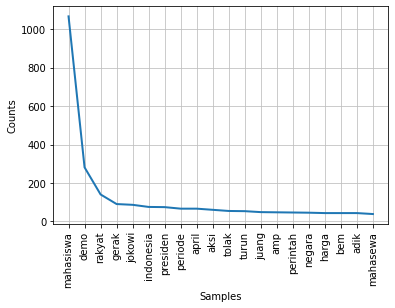

(demo, mahasiswa)         71
(mahasiswa, gerak)        63
(mahasiswa, demo)         63
(adik, mahasiswa)         30
(mahasiswa, mahasiswa)    29
(demo, april)             25
(gerak, mahasiswa)        24
(bem, si)                 22
(rakyat, mahasiswa)       20
(mahasiswa, rakyat)       18
(mahasiswa, indonesia)    18
(presiden, periode)       18
(jabat, presiden)         18
(aksi, mahasiswa)         17
(mahasiswa, mahasewa)     17
(gera, mahasiswa)         16
(hidup, mahasiswa)        16
(naik, harga)             16
(tunda, milu)             15
(rakyat, indonesia)       14
dtype: int64


In [ ]:
# Melakukan analisis keseluruhan data yang telah digabung
tp.char_frequency(df_clean, 'clean_data')
tp.word_length(df_clean, 'clean_data')
tp.mean_word_length(df_clean, 'clean_data')
tp.word_frequency(df_clean, 'clean_data')
tp.bi_diagram(df_clean, 'clean_data', 20)


In [ ]:
with open("./kata_positif.txt", "r") as positif_file:
    positive_words = list(set(positif_file.readlines()))
with open("./kata_negatif.txt", "r") as negative_file:
    negative_words = list(set(negative_file.readlines()))

def analyze_sentiment(df):
    hasil = []
    for tweet in df:
        tweet_clean = tweet.strip().split()

        good_count = 0  # nilai positif
        bad_count = 0  # nilai negatif

        for good_word in positive_words:
            count = tweet_clean.count(good_word.strip().lower())
            if count > 0:
                good_count += count

        for bad_word in negative_words:
            count = tweet_clean.count(bad_word.strip().lower())
            if count > 0:
                bad_count += count

        hasil.append(good_count - bad_count)
    return hasil


In [ ]:
# Melakukan Sentiment Analysis
hasil = analyze_sentiment(df_clean['clean_data'])
sentiments = ["positif" if sentimen > 0 else ("netral" if sentimen == 0 else "negatif") for sentimen in hasil]
df_clean["sentiment"] = sentiments
display(df_clean.head())

print(f'''
    Mean: {np.mean(hasil)}
    Median: {np.median(hasil)}
    quartil awal: {np.quantile(hasil,0.25)}
    quartil akhir: {np.quantile(hasil,0.75)}
    Standar deviasi: {np.std(hasil)}     
''')


,date,clean_data,sentiment
0,2022-04-05,bangga mahasiswa itb kalah ilmu ngembangin tek...,netral
1,2022-04-05,mahasiswa dongok kualitas mahasiswa,netral
2,2022-04-05,biar mahasiswa gerak rakyat buruh stm satu bar...,netral
3,2022-04-05,temanpemilih sedulurkpubanyumas kpu banyumas l...,netral
4,2022-04-05,bisaa nomor dm wa diskusi nego mahasiswa sasin...,netral



    Mean: -0.33426443202979517
    Median: 0.0
    quartil awal: -1.0
    quartil akhir: 0.0
    Standar deviasi: 1.5007754261702089     



In [ ]:
def plot_sentiment(labels, counts):
    fig, ax = plt.subplots()
    ax.set_xticks(ax.get_xticks())

    sns.barplot(x=list(labels),
                y=list(counts))

    sns.lineplot(x=ax.get_xticks(),
                y=list(counts))

    plt.title(f'Distribution Sentiment')
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.show()


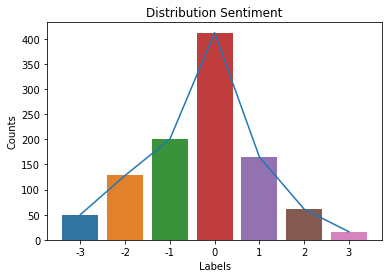

<AxesSubplot:xlabel='sentiment'>

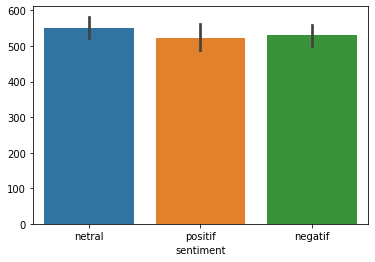

In [ ]:
# Find value of counts
unique, counts = np.unique(np.array(hasil), return_counts=True)
result = dict(zip(unique, counts))

labels = np.arange(-3, 4)
counts = list(map(lambda x: result.get(x) if result.get(x) else 0, labels))

# plot sentiment analysis
plot_sentiment(labels, counts)
sns.barplot(x=df_clean['sentiment'],y=df_clean['sentiment'].index)

In [ ]:
def plot_word(data, file_name):

    text = ' '.join(data.to_list())

    parrot_color = np.array(Image.open(os.path.join("parrot-by-jose-mari-gimenez2.jpg")))
    parrot_color = parrot_color[::3, ::3]

    parrot_mask = parrot_color.copy()
    parrot_mask[parrot_mask.sum(axis=2) == 0] = 255

    edges = np.mean([gaussian_gradient_magnitude(parrot_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
    parrot_mask[edges > .08] = 255

    wc = WordCloud(max_words=2000, mask=parrot_mask, max_font_size=40, random_state=42, relative_scaling=0)
    wc.generate(text)
    image_colors = ImageColorGenerator(parrot_color)
    wc.recolor(color_func=image_colors)
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation="bilinear")
    wc.to_file(file_name)



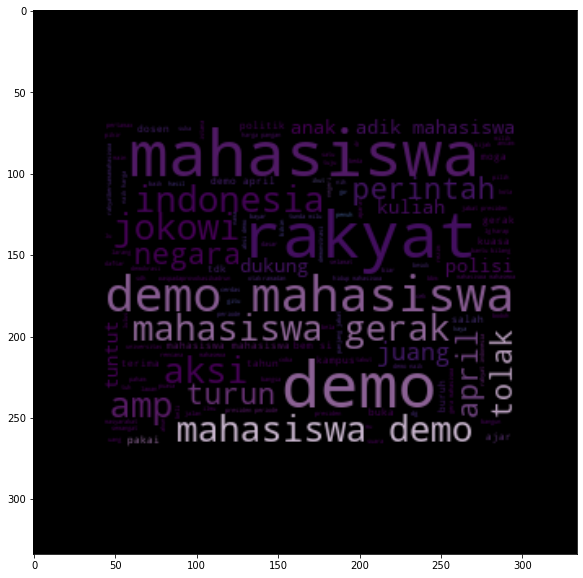

In [ ]:
plot_word(df_clean['clean_data'], "mahasiswa.png")


In [ ]:
# Sentiment Analysis - Machine Learning

df_clean2 = df_clean.replace({"sentiment":{"negatif":-1, "netral":0, "positif":1}})
vectorizer = TfidfVectorizer (max_features=2500)
model_g = GaussianNB()
v_data = vectorizer.fit_transform(df_clean['clean_data'])
print(v_data[0])


  (0, 775)	0.2897458893412793
  (0, 1638)	0.378231694707801
  (0, 1229)	0.3001618025089035
  (0, 2036)	0.378231694707801
  (0, 2137)	0.35718582476236815
  (0, 859)	0.2810748632298625
  (0, 965)	0.3422535423997693
  (0, 892)	0.33067116436967725
  (0, 1147)	0.05993091803223588
  (0, 243)	0.3212076724543364


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(v_data.toarray(), df_clean2['sentiment'], test_size=0.2, random_state=24)
model_g.fit(X_train,y_train)
y_preds = model_g.predict(X_test)
print(confusion_matrix(y_test,y_preds))
print(classification_report(y_test,y_preds))
print('nilai akurasinya adalah ',accuracy_score(y_test, y_preds))

[[51 19  9]
 [20 39 20]
 [14  8 35]]
              precision    recall  f1-score   support

          -1       0.60      0.65      0.62        79
           0       0.59      0.49      0.54        79
           1       0.55      0.61      0.58        57

    accuracy                           0.58       215
   macro avg       0.58      0.58      0.58       215
weighted avg       0.58      0.58      0.58       215

nilai akurasinya adalah  0.5813953488372093


In [ ]:
v_data = vectorizer.transform(df_clean2["clean_data"]).toarray()
y_classification = model_g.predict(v_data)
df_clean2["sentiment"] = list(y_classification)
df_clean2[df_clean2['sentiment'] == 0]


,date,clean_data,sentiment
0,2022-04-05,bangga mahasiswa itb kalah ilmu ngembangin tek...,0
1,2022-04-05,mahasiswa dongok kualitas mahasiswa,0
3,2022-04-05,temanpemilih sedulurkpubanyumas kpu banyumas l...,0
4,2022-04-05,bisaa nomor dm wa diskusi nego mahasiswa sasin...,0
6,2022-04-05,demi rumah ku tinggal rantau tagih juta ngambi...,0
...,...,...,...
1063,2022-04-05,sejarah kota malang nama nama juluk,0
1065,2022-04-05,akun sscasn daftar sekolah dinas,0
1066,2022-04-05,prospek karier prodi bisnis digital kampus,0
1069,2022-04-05,kisah puasa ramadhan jerman buka pakai nasi kotak,0


In [ ]:
def bi_diagram2(data, column, count, column_query, query):
    df = data[data[column_query] == query]
    tweet_data = data[column].apply(
        lambda x: tp.tokenizing(str(x)))
    tweets = [word for tweet in tweet_data for word in tweet]
    result = pd.Series(nltk.ngrams(tweets, 2)).value_counts()[:count]
    print(result)


(demo, mahasiswa)         71
(mahasiswa, gerak)        63
(mahasiswa, demo)         63
(adik, mahasiswa)         30
(mahasiswa, mahasiswa)    29
(demo, april)             25
(gerak, mahasiswa)        24
(bem, si)                 22
(rakyat, mahasiswa)       20
(mahasiswa, rakyat)       18
dtype: int64


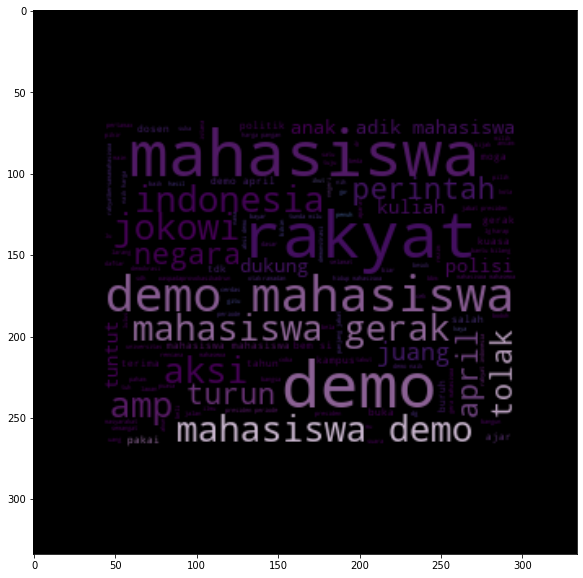

In [ ]:
bi_diagram2(df_clean2, 'clean_data', 10, 'sentiment', -1)
plot_word(df_clean2['clean_data'], "negatif.png")


(demo, mahasiswa)         71
(mahasiswa, gerak)        63
(mahasiswa, demo)         63
(adik, mahasiswa)         30
(mahasiswa, mahasiswa)    29
(demo, april)             25
(gerak, mahasiswa)        24
(bem, si)                 22
(rakyat, mahasiswa)       20
(mahasiswa, rakyat)       18
dtype: int64


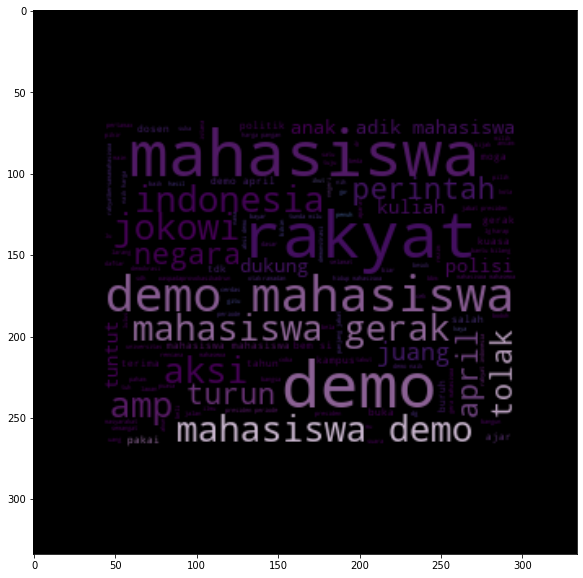

In [ ]:
bi_diagram2(df_clean2, 'clean_data', 10, 'sentiment', 0)
plot_word(df_clean2['clean_data'], "netral.png")


(demo, mahasiswa)         71
(mahasiswa, gerak)        63
(mahasiswa, demo)         63
(adik, mahasiswa)         30
(mahasiswa, mahasiswa)    29
(demo, april)             25
(gerak, mahasiswa)        24
(bem, si)                 22
(rakyat, mahasiswa)       20
(mahasiswa, rakyat)       18
dtype: int64


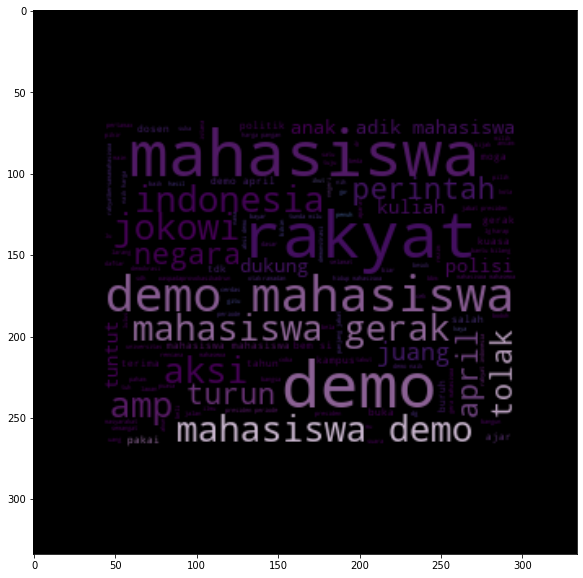

In [ ]:
bi_diagram2(df_clean2, 'clean_data', 10, 'sentiment', 1)
plot_word(df_clean2['clean_data'], "positif.png")


In [ ]:
# Network Analysis
tweet_gram = [word for tweet in df_clean2['clean_data'] for word in tweet.split()]
fdist = nltk.FreqDist(nltk.ngrams(tweet_gram, 2))
list_data = [[k, v]for k, v in fdist.items()]
df_bigram = pd.DataFrame(list_data, columns=['bigram', 'count'])
df_bigram_sort = df_bigram.sort_values(
    by=["count"], ascending=False).copy().reset_index(drop=True)[:1642]
df_bigram_sort


,bigram,count
0,"(demo, mahasiswa)",71
1,"(mahasiswa, gerak)",63
2,"(mahasiswa, demo)",63
3,"(adik, mahasiswa)",30
4,"(mahasiswa, mahasiswa)",29
...,...,...
1637,"(tdk, laksana)",1
1638,"(laksana, tdk)",1
1639,"(dzikir, ngajak)",1
1640,"(americasgp, sayabersamajokowi)",1


In [ ]:
d = df_bigram_sort.set_index("bigram").T.to_dict("records")
# print(d.values())
G = nx.Graph()

nodes_size = []
for k,v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v*10))

deg = dict(G.degree)


AttributeError: 'list' object has no attribute 'values'

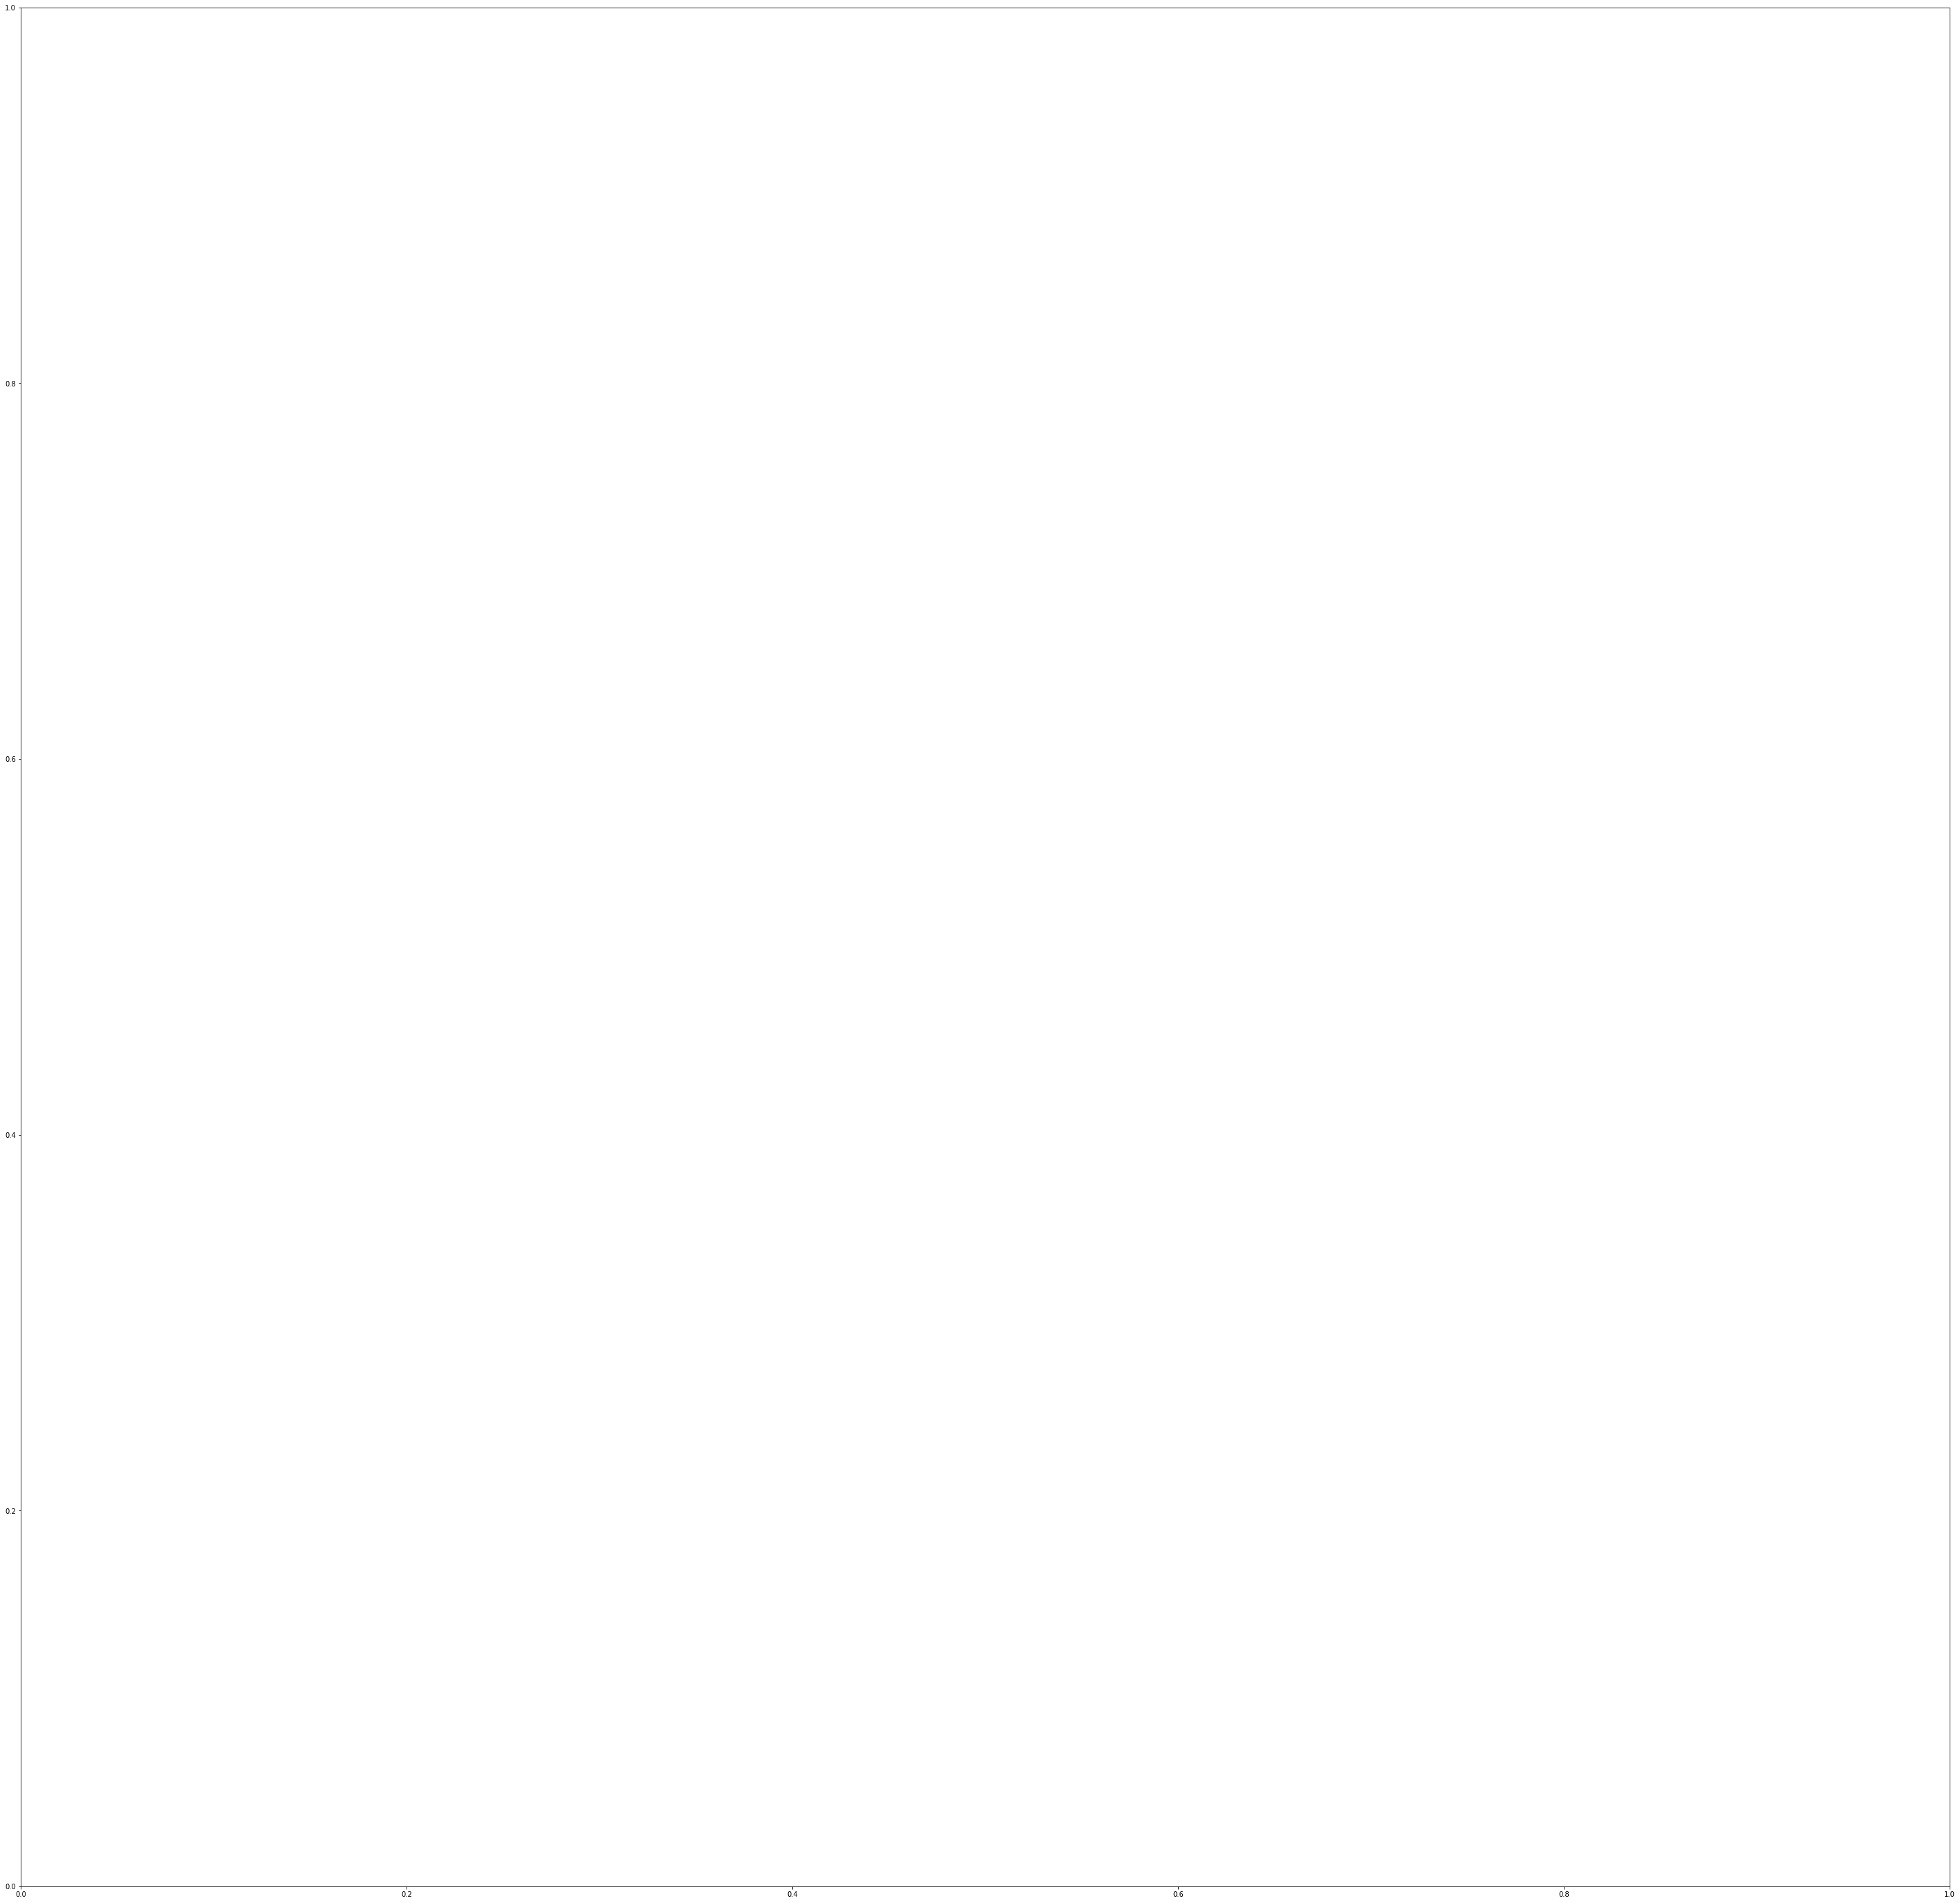

In [ ]:
fig, ax = plt.subplots(figsize=(50, 50))
pos = nx.spring_layout(G, k=2.5)

# Plot networks
nx.draw_networkx(G, pos,
                font_size=12,
                width=1,
                edge_color='grey',
                node_color='purple',
                with_labels=False,
                node_size=[v * 100 for v in d.values()],
                ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.025, value[1]+.015
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='grey', alpha=0.25),
            horizontalalignment='center', fontsize=12)

plt.show()


Business Understanding
- Saya memilih topik mahasiswa adalah karena akhir-akhir ini sedang diberitakan bahwasannya mahasiswa akan menuntut pemerintah, namun saya ingin mencoba apakah dari sentimen masyarakat akan berpikir apakah aksi tersebut akan berpengaruh pada aspek lain misalnya terkait pangan yang saat ini sedan turun.

1. Text Analysis
- Dari data distribusi frekuensi jumlah karakter per data, terlihat distribusi terbanyak berada pada tweet yang memiliki 30-70 karakter, dengan tweet yang memiliki jumlah karakter di bawah 50, tidak lebih dari 20 tweet.
- Dari data distribusi frekuensi jumlah kata per data, terlihat bahwa distribusi terbanyak berada pada 5-10 kata per tweet. Tweet dengan jumlah kata di atas 15 kata tidak terlalu signifikan.
- Dari data distribusi frekuensi panjang kata rata-rata, terlihat distribusi terbanyak berada pada 5-7 karakter per tweet.
- Dari data distribusi frekuensi data, terlihat bahwa kata 'mahasiswa' berada pada urutan teratas, sehingga terlihat bahwa berita yang paling banyak diberitakan pada hari tersebut adalah mengenai kota mahasiswa yang melakukan gerakan demo.
- Dari hasil bi-gram, menunjukkan bahwa yang paling banyak dibicarakan adalah mengenai aksi demo mahasiswa di bulan april oleh bem si kepada presiden, dan juga perihal penundaan pemilu.
- Untuk sentimen negatif, netral, maupun positif, banyak yang membahas mengenai demo mahasiswa di bulan april

2. Sentiment Analysis
Hasil dari statistika deskriptif menunjukkan bahwa data sentimen untuk topik "Mahasiswa" merupakan left skewed distribution, dimana nilai dari mean lebih kecil dari median. Dari distribusi plot secara kategorikal, terlihat bahwa tweet netral sedikit lebih mendominasi, dan memiliki selisih yang tidak signifikan dengan tweet positif dan negatif.

3. Data Analysis
- Bagaimana gambaran keadaan mahasiswa di Indonesia saat ini?
Mahasiswa di Indonesia dikabarkan menggelar aksi demo
- Apa sentimen sosial media terhadap mahasiswa?
Sentimen yang dihasilkan lebih banyak sentimen netral, namun tidak memiliki perbedaan signifikan dengan sentimen positif dan negatif
- Permasalahan apa yang diangkat oleh mahasiswa saat ini?
Saat ini mahasiswa cenderung berfokus pada topik aksi demo yang menuntut atas pemerintahan presiden Jokowi.
- Apakah dari masyarakat berpikir bahwa aksi mahasiswa akan berpengaruh pada aspek lainnya?
Dari data yang didapatkan, belum ada data signifikan yang menunjukkan bahwa masyarakat concern dengan isu selain aksi demo yang bisa berpengaruh karena adanya kegiatan dari mahasiswa.